# Assignment 2

In this assignment, you need to implement the followings.


---


*   [1.1 Encoder](#encoder)
*   [1.2 Decoder](#decoder)
*   [1.3 Reparametrization Trick](#reparam)
*   [1.4 Loss Function](#loss)



# Import

In [ ]:
# Imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import gridspec

#GPU setting

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Hyperparameter setting

In [ ]:
batch_size = 100      
e_hidden = 256        # the number of hidden units in the encoder.
d_hidden = 256        # the number of hidden units in the decoder.
latent_dim = 2        
learning_rate = 0.001 
weight_decay = 1e-5   
epochs = 500          # the number of epochs

#Data Loading

In [ ]:
# Set up Transformations (0-1 Scaling only)
t = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=t)
testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=t)

# Load train and test set
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Variational Auto-Encoder

<a name="encoder"></a>
# 1.1 Encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, in_features=28*28, e_hidden=200, latent_dim=2):
        """Encoder Class"""
        super(Encoder, self).__init__()
        # Encoder
        ##################################### 
        self.h = nn.Sequential(nn.Linear(in_features, e_hidden),
                               nn.ReLU())
        self.mu = nn.Linear(e_hidden, latent_dim)
        self.logvar = nn.Linear(e_hidden, latent_dim)
        ##################################### 
        
    def forward(self, x):
        # Encode x to z
        ##################################### 
        h = self.h(x.view(x.size(0), -1))
        mu = self.mu(h)
        logvar = self.logvar(h)

        ##################################### 
        
        return mu, logvar

<a name="decoder"></a>
# 1.2 Decoder

In [29]:
class Decoder(nn.Module):
    def __init__(self, in_features=28*28, d_hidden=200, latent_dim=2):
        """Decoder Class"""
        super(Decoder, self).__init__()

        # Decoder
        ##################################### 
        self.h = nn.Sequential(nn.Linear(latent_dim, d_hidden),
                                     nn.ReLU())
        self.x_recon = nn.Sequential(nn.Linear(d_hidden, in_features),
                               nn.Sigmoid())
        ##################################### 
        

    def forward(self, z):        
        # Decode z to x'
        ##################################### 
        # Write your code here
        ##################################### 
        x_recon = (self.x_recon((self.h(z))))
        return x_recon

<a name="reparam"></a>
# 1.3 Reparametrization Trick

In [30]:
class VAE(nn.Module):
    def __init__(self, in_features=28*28, e_hidden=200, d_hidden=200, latent_dim=2):
        """Variational Auto-Encoder Class"""
        super(VAE, self).__init__()
        
        self.encoder = Encoder(in_features, e_hidden, latent_dim)
        self.decoder = Decoder(in_features, d_hidden, latent_dim)
    
    # Reparameterization Trick
    def reparameterize(self, mu, logvar):
        ##################################### 
        # Write your code here
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdw)

        z = mu + eps * std
        ##################################### 

        return z

    def forward(self, x):
        # Encode x to z
        mu, logvar = self.encoder(x)
        
        # Sample z from mu and logvar
        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        
        # Decode z to x'
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar

<a name="loss"></a>
# 1.4 Loss for VAE

In [31]:
# Loss
def vae_loss(image, reconstruction, mu, logvar):
  """
  Loss for the Variational AutoEncoder.
  The loss can be composed of two terms, reconstruction loss and the KL divergence loss.
  Please not that we try to minimize the loss, not to maximize.
  """

  ##################################### 
  # Write your code here
  BCE = torch.nn.BCELoss(reduction='sum')

  loss = BCE(reconstruction, image.view(-1, 784)) -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  
  
  #####################################
  return loss

#Training

In [32]:
# Initialize VAE
vae = VAE(in_features=28*28, e_hidden=e_hidden, d_hidden=d_hidden, latent_dim=latent_dim)
vae = vae.to(device)
# Optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()

# Train
losses = []

for epoch in range(epochs):
  losses.append(0)
  number_of_batches = 0

  for images, _ in trainloader:

    images = images.to(device)
    # Flatten images to [batch_size, input_features]
    images = images.view(-1, 28*28)

    optimizer.zero_grad()
    
    # Feed inputs to VAE
    reconstructions, latent_mu, latent_logvar = vae(images)
    loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)/batch_size

    # Backpropagation
    loss.backward()
    optimizer.step()

    losses[-1] += loss.item()  
    number_of_batches += 1
  
  # Print average loss
  losses[-1] /= number_of_batches
  print('Epoch [%d / %d] Loss: %f' % (epoch+1, epochs, losses[-1]))    

Epoch [1 / 500] Loss: 192.524922
Epoch [2 / 500] Loss: 168.980491
Epoch [3 / 500] Loss: 163.933682
Epoch [4 / 500] Loss: 161.221637
Epoch [5 / 500] Loss: 159.394611
Epoch [6 / 500] Loss: 157.982324
Epoch [7 / 500] Loss: 156.818870
Epoch [8 / 500] Loss: 155.851470
Epoch [9 / 500] Loss: 155.047971
Epoch [10 / 500] Loss: 154.331885
Epoch [11 / 500] Loss: 153.730719
Epoch [12 / 500] Loss: 153.200464
Epoch [13 / 500] Loss: 152.593325
Epoch [14 / 500] Loss: 152.159229
Epoch [15 / 500] Loss: 151.753322
Epoch [16 / 500] Loss: 151.367473
Epoch [17 / 500] Loss: 150.998309
Epoch [18 / 500] Loss: 150.689372
Epoch [19 / 500] Loss: 150.360210
Epoch [20 / 500] Loss: 150.023370
Epoch [21 / 500] Loss: 149.842570
Epoch [22 / 500] Loss: 149.550886
Epoch [23 / 500] Loss: 149.330205
Epoch [24 / 500] Loss: 149.085720
Epoch [25 / 500] Loss: 148.905179
Epoch [26 / 500] Loss: 148.664269
Epoch [27 / 500] Loss: 148.485172
Epoch [28 / 500] Loss: 148.306831
Epoch [29 / 500] Loss: 148.115016
Epoch [30 / 500] Loss: 

#Reconstruction Test

In [33]:
def reconstruction_images(images, labels):
  gs = gridspec.GridSpec(10,11,width_ratios=[1,1,1,1,1,0.3,1,1,1,1,1])
  plt.figure(figsize=[16,15])

  reconstructions, latent_mu, latent_logvar = vae(images)
  loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)/batch_size

  # Compare true images and reconstructed images
  for i in range(10):
    label = np.where(labels==i)[0][:5]
    for j,idx in enumerate(label):
      true_sample = images[idx].view(28, 28).cpu().detach().numpy()
      recon_sample = reconstructions[idx].view(28, 28).cpu().detach().numpy()
      
      if i <= 4:
        k = i*2
        l = j
      else:
        k = (i-5)*2
        l = j+6
      plt.subplot(gs[k,l]) 
      plt.imshow(true_sample, cmap='gray_r')
      plt.xticks([])
      plt.yticks([])
      if j ==0:
        plt.ylabel('Label: {}\nTrue'.format(i), fontsize=15)

      plt.subplot(gs[k+1,l])
      plt.imshow(recon_sample, cmap='gray_r')
      plt.xticks([])
      plt.yticks([])
      if j ==0:
        plt.ylabel('Recon'.format(i), fontsize=15)

  plt.savefig('reconstruction_results.png')
  plt.show()


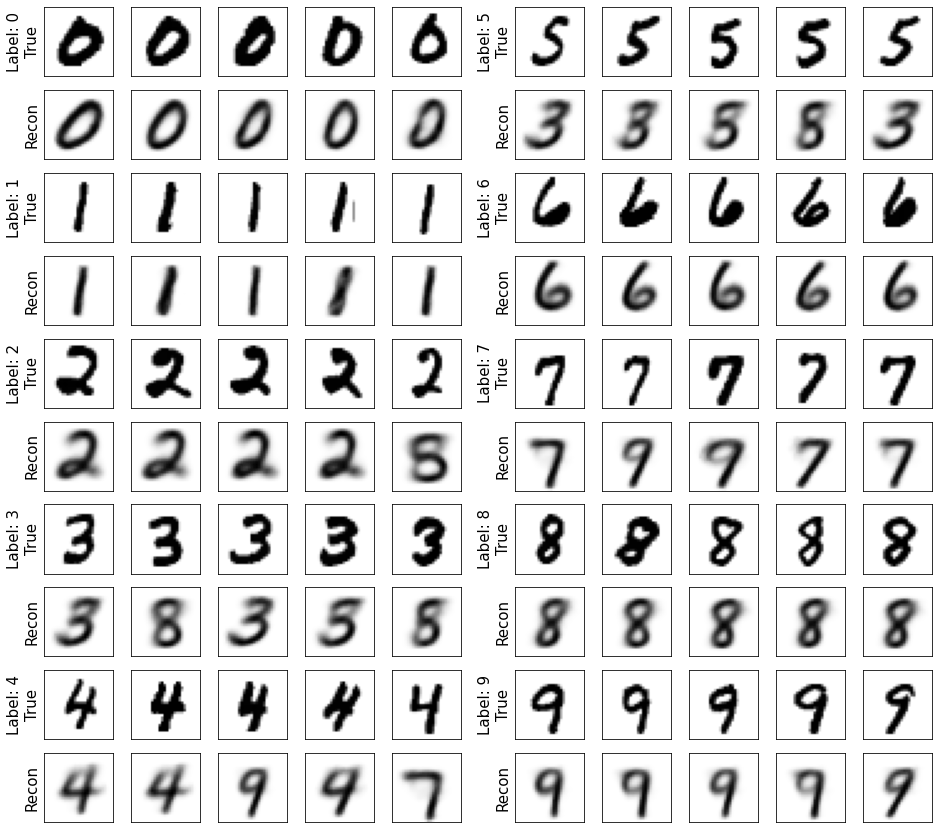

In [34]:
vae.eval()

for images, labels in testloader:
  if torch.sum(labels)!= 450: continue
  images = images.to(device).view(-1, 28*28)
  optimizer.zero_grad()
  reconstruction_images(images,labels)
  break

# Visualize Latent Space

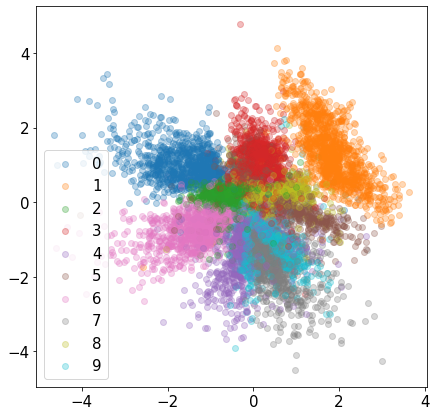

In [35]:
plt.figure(figsize=[7,7])
first = True

for images, labels in testloader:
  images = images.to(device).view(-1, 28*28)
  optimizer.zero_grad()
  _, latent_mu, latent_logvar = vae(images)

  latent_mu, latent_logvar = latent_mu.detach().cpu(), latent_logvar.detach().cpu()
  for i in range(10):
    idx = np.where(labels==i)[0]
    if first:
      plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3, label='{}'.format(i))
    else:
      plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3)
  first = False
  
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('latent_space.png')
plt.show()